# Spatial stream

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from IPython.core.display import Image

from pathlib import Path
import os

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Testing if cuda is on GPU

In [20]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


## From scratch

### Generator

Set parametri

In [21]:
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 64
num_classes = 51

num_frames_desired = 17     #number of frames per clip
type_frame = 'img'          #img / flow_x / flow_y

Dataset generation

In [22]:
def sampling(list, num_frames_desired):
    step = len(list) // (num_frames_desired)
    #selected_frames = list(range(0, len(list), step))[:num_frames_desired]
    sampled_list = list[0:len(list):step][:num_frames_desired]
    return(sampled_list)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def find_paths(partition, type_frame, num_frames_desired):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")

    #temp_path = video_list.loc[0]['path'] #da togliere!!!

    paths = []
    classes = []
    for index, row in video_list.iterrows(): #da togliere [:1]
        temp_path = row['path']                    #da rimuovere il commentato
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = sampling(frame_list_type, num_frames_desired)

        paths.extend([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * 10
        classes.extend(temp)

    return(list(zip(paths, classes)))

In [23]:
# ------- create train set
filenames = find_paths(partition='train', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
train_ds = configure_for_performance(ds)

In [24]:
frame_number_train = len(filenames)
print(frame_number_train)

35700


In [25]:
# ------- create val test
filenames = find_paths(partition='val', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
val_ds = configure_for_performance(ds)

In [26]:
frame_number_val = len(filenames)
print(frame_number_val)

15300


### Model

In [27]:
checkpoint_filepath = './Models/spatial_model{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    # layers.RandomZoom(0.2),
    layers.RandomCrop(224,224)
    # layers.RandomHeight(0.2),
    # layers.RandomWidth(0.2),
    # layers.Resizing(224,224)
])

In [12]:
num_classes = 51

model_spat = keras.models.Sequential()

data_augmentation

model_spat.add(keras.layers.Conv2D(96, (7,7), strides = 2, input_shape=(224, 224, 3), activation = "relu"))
model_spat.add(keras.layers.BatchNormalization())
model_spat.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(256, (5,5), strides = 2, activation='relu'))
model_spat.add(keras.layers.BatchNormalization())
model_spat.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))
          
model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))
model_spat.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_spat.add(keras.layers.Flatten())

model_spat.add(keras.layers.Dense(4096, activation='relu'))
model_spat.add(keras.layers.Dropout(0.5))      #valore dropout 0.5 oppure 0.9? paper li usa entrambi 

model_spat.add(keras.layers.Dense(2048, activation='relu'))
model_spat.add(keras.layers.Dropout(0.5))

model_spat.add(keras.layers.Dense(num_classes, activation="softmax"))

In [14]:
model_spat.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 96)      14208     
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 57, 57, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                      

In [28]:
model_spat.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy','sparse_categorical_accuracy'], 
              optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [29]:
step_per_epoch_train = frame_number_train // batch_size
step_per_epoch_val = frame_number_val // batch_size
print(step_per_epoch_train)
print(step_per_epoch_val)



557
239


In [30]:
history_cnn_spatial_stream = model_spat.fit(train_ds, 
                                            validation_data = val_ds, 
                                            validation_steps=step_per_epoch_val, 
                                            batch_size=64, 
                                            epochs=100, 
                                            steps_per_epoch=step_per_epoch_train, 
                                            callbacks=[model_checkpoint_callback])

Epoch 1/100
557/557 [==============================] - 252s 448ms/step - loss: 3.7728 - accuracy: 0.0414 - sparse_categorical_accuracy: 0.0414 - val_loss: 4.0078 - val_accuracy: 0.0431 - val_sparse_categorical_accuracy: 0.0431
Epoch 2/100
557/557 [==============================] - 193s 345ms/step - loss: 3.7258 - accuracy: 0.0452 - sparse_categorical_accuracy: 0.0452 - val_loss: 3.8919 - val_accuracy: 0.0352 - val_sparse_categorical_accuracy: 0.0352
Epoch 3/100
557/557 [==============================] - 130s 233ms/step - loss: 3.6958 - accuracy: 0.0516 - sparse_categorical_accuracy: 0.0516 - val_loss: 3.8123 - val_accuracy: 0.0275 - val_sparse_categorical_accuracy: 0.0275
Epoch 4/100
557/557 [==============================] - 87s 156ms/step - loss: 3.6447 - accuracy: 0.0559 - sparse_categorical_accuracy: 0.0559 - val_loss: 3.8038 - val_accuracy: 0.0581 - val_sparse_categorical_accuracy: 0.0581
Epoch 5/100
557/557 [==============================] - 87s 157ms/step - loss: 3.6303 - accura

### Evaluation

In [35]:
score = model_spat.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])

239/239 [==============================] - 69s 282ms/step - loss: 13.7399 - accuracy: 0.0662 - sparse_categorical_accuracy: 0.0662
Loss val: 13.739862442016602
Sparse_categorical_accuracy: 0.06616108864545822


In [6]:
model_spat_charged = keras.models.load_model('./Models/spatial_model59-9.54.hdf5')
model_spat_charged.save('./Models/model_spat.h5')

In [7]:
model_spat_charged.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 96)      14208     
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 57, 57, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                      

In [40]:
keras.utils.plot_model(model_spat, to_file='./Models/model_spat.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


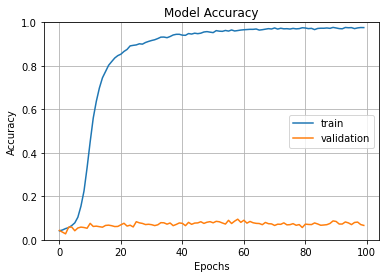

In [32]:
fig1 = plt.gcf()
plt.plot(history_cnn_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_cnn_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('./Plots/resnet1_0.png')
plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history_cnn_spatial_stream.history['loss'])
plt.plot(history_cnn_spatial_stream.history['val_loss'])
plt.ylim([0.0, 9.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_cnn_spatial_stream.history['accuracy'])
plt.plot(history_cnn_spatial_stream.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

## Transfer Learning

### Generator

In [ ]:
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 64
num_classes = 51

num_frames_desired = 17     #number of frames per clip
type_frame = 'img'          #img / flow_x / flow_y

In [ ]:
def sampling(list, num_frames_desired):
    step = len(list) // (num_frames_desired)
    #selected_frames = list(range(0, len(list), step))[:num_frames_desired]
    sampled_list = list[0:len(list):step][:num_frames_desired]
    return(sampled_list)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def find_paths(partition, type_frame, num_frames_desired):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")

    #temp_path = video_list.loc[0]['path'] #da togliere!!!

    paths = []
    classes = []
    for index, row in video_list.iterrows(): #da togliere [:1]
        temp_path = row['path']                    #da rimuovere il commentato
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = sampling(frame_list_type, num_frames_desired)

        paths.extend([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * num_frames_desired
        classes.extend(temp)

    return(list(zip(paths, classes)))

Create train set

In [ ]:
# ------- create train set
filenames = find_paths(partition='train', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
train_ds = configure_for_performance(ds)

In [ ]:
frame_number_train = len(filenames)
print(frame_number_train)

60690


Create val test

In [ ]:
# ------- create val test
filenames = find_paths(partition='val', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
val_ds = configure_for_performance(ds)

In [ ]:
frame_number_val = len(filenames)
print(frame_number_val)

26010


In [ ]:
step_per_epoch_train = frame_number_train // batch_size
step_per_epoch_val = frame_number_val // batch_size
print(step_per_epoch_train)
print(step_per_epoch_val)

948
406


Checkpoint definition

In [ ]:
checkpoint_filepath = './Models/spatial_model{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

### Model 1

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomCrop(img_height, img_width)
])

input = tf.keras.layers.Input(shape=(img_height, img_width, 3))

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_tensor=input,
                                                  pooling='avg',
                                                  weights='imagenet')
pretrained_model.trainable = False



resnet_model = Sequential()
data_augmentation

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))

print(resnet_model.summary())

resnet_model.compile(optimizer = Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 51)                26163     
                                                                 
Total params: 24,662,963
Trainable params: 1,075,251
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
history_ResNet1_spatial_stream = resnet_model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        epochs=1, 
                                        steps_per_epoch=step_per_epoch_train,
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback])

948/948 [==============================] - 530s 552ms/step - loss: 0.8065 - sparse_categorical_accuracy: 0.7843 - sparse_top_k_categorical_accuracy: 0.9301 - val_loss: 3.3858 - val_sparse_categorical_accuracy: 0.3196 - val_sparse_top_k_categorical_accuracy: 0.6477


### Evaluation

In [ ]:
score = resnet_model.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])
print('Sparse_top_5_categorical_accuracy:', score[2])

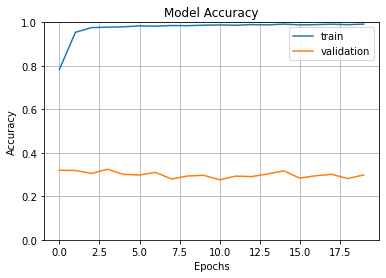

In [ ]:
fig1 = plt.gcf()
plt.plot(history_ResNet1_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet1_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('./Plots/resnet1_0.png')
plt.show()

### Model 2

In [ ]:
def build_model(num_classes, img_size=224):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.ResNet50(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="ResNet")
    #model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy'])
    model.compile(optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,), 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = ['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])
                    
    return model 

model = build_model(num_classes)
print(model.summary())

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [ ]:
history_ResNet2_spatial_stream = model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        batch_size=batch_size, 
                                        epochs=5, 
                                        steps_per_epoch=step_per_epoch_train, 
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback])

### Evaluation

In [ ]:
score = model.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])
print('Sparse_top_5_categorical_accuracy:', score[2])

406/406 [==============================] - 125s 308ms/step - loss: 2.7244 - sparse_categorical_accuracy: 0.3468 - sparse_top_k_categorical_accuracy: 0.6810
Loss val: 2.724404811859131
Sparse_categorical_accuracy: 0.3467518389225006
Sparse_top_5_categorical_accuracy: 0.681034505367279


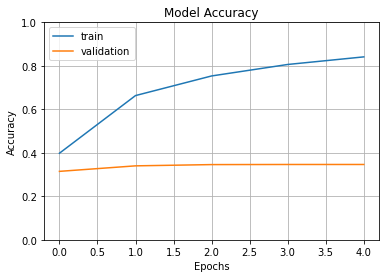

In [ ]:
fig2 = plt.gcf()
plt.plot(history_ResNet2_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet2_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('./Plots/resnet2_1.png')
plt.show()